# Model building and hyperparameter tuning

## Contents

* 5.1 Introduction
* 5.2 Imports
* 5.3 Load Data
* 5.4 Modeling
    * 5.4.1 Performance of previous models
    * 5.4.2 Light FM model
    * 5.4.3 Hyperparameter tuning for LightFM model
* 5.5 Making sample recommendations
* 5.6 Business impact
* 5.7 Summary
* 5.8 Future Work

## 5.1 Introduction

In this notebook, the user-product interaction matrix is used along with the LightFM model to apply collaborative filtering and recommend products to customer. The training set and test set are seperate and used for checing the performance. 

Mean Average Precision is the metric that is used to evaluate model performance and the k value is selected to be 8.

## 5.2 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import pickle
from scipy.sparse import coo_matrix # for constructing sparse matrix  # lightfm 
from lightfm import LightFM # model
from lightfm.evaluation import precision_at_k
import time

C:\Users\krven\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


## 5.3 Load Data

Load the pickled user-product interaction files for training, testing and product names

In [2]:
a_file = open("../data/user_product_int_scaled.pkl", "rb")
user_product_int_scaled = pickle.load(a_file)
a_file.close()

In [3]:
a_file = open("../data/test_user_product_interaction_top1000.pkl", "rb")
test_user_product_interaction_top1000 = pickle.load(a_file)
a_file.close()

In [4]:
a_file = open("../data/products_in_matrix.pkl", "rb")
products_in_matrix = pickle.load(a_file)
a_file.close()

## 5.4 Modeling 

## 5.4.1 Performance of previous models:

There were 4 models tested in the preprocessing section. The models and their performances are shown below:

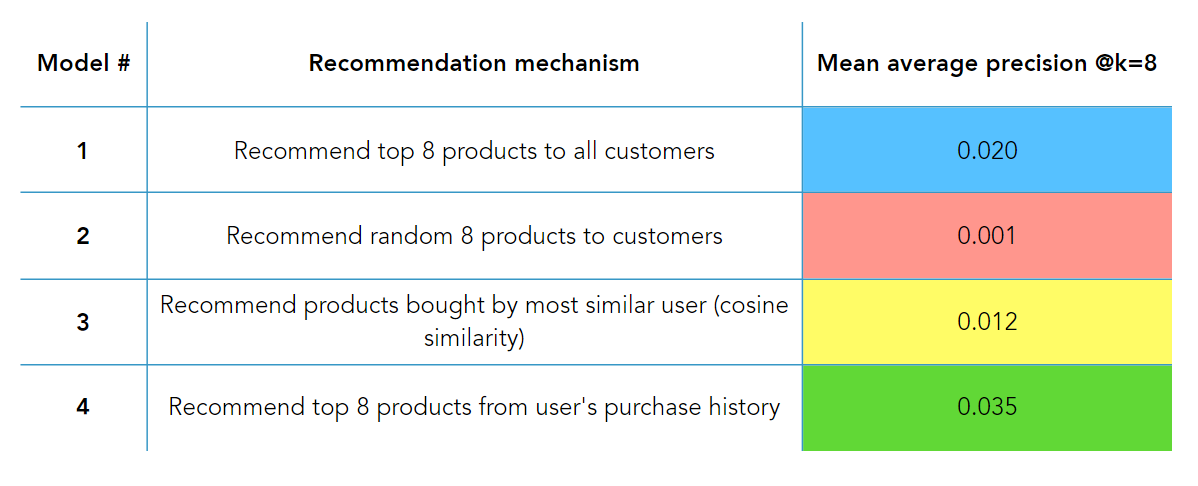

## 5.4.2 Model 5: LightFM model

In [5]:
#The lightFM model needs the size of training and testing to be the same. So, we only train for users in the training set
users_in_both=list(set(user_product_int_scaled.index).intersection(set(test_user_product_interaction_top1000.index)))
train_set=user_product_int_scaled.loc[users_in_both,:]
test_set=test_user_product_interaction_top1000.loc[users_in_both,:]
test_set.columns=products_in_matrix

In [6]:
test_set=coo_matrix(test_set)
train_set=coo_matrix(train_set)

In [7]:
# initialising model with warp loss function
model = LightFM(loss = "warp")

# fitting into user to product interaction matrix only / pure collaborative filtering factor
start = time.time()

model.fit(train_set, user_features=None, item_features=None, 
sample_weight=None, epochs=10, num_threads=4,verbose=False)

end = time.time()
print("time taken = ",round(end - start, 2),"seconds")

time taken =  114.05 seconds


In [8]:
ap = precision_at_k(model = model, 
                        test_interactions = test_set,
                        num_threads = 4,k=8, check_intersections = False)

print("average MAP = {0:.{1}f}".format(ap.mean(), 4))

average MAP = 0.1102


### The MAP score when recommending products using LightFM model with default learning rate and 20 epochs is 0.109

### This model is performing 3x better than our simple recommendation models. So, it is time to identify the hyperparameters for this model that maximizes the MAP value.

## 5.4.3 Hyperparameter tuning for LightFM model

In [9]:
# Calculate and return MAPs
def MAP_for_lightfm_model(learning_rate,epoch):
    model = LightFM(loss = "warp",learning_rate=learning_rate)
    model.fit(train_set,
          user_features=None, 
          item_features=None, 
          sample_weight=None, 
          epochs=epoch, 
          num_threads=4,
          verbose=False)
    ap_current = precision_at_k(model = model, 
                        test_interactions = test_set,
                        num_threads = 4,k=8, check_intersections = False)
    return round(ap_current.mean(),4)

In [10]:
#Dataframe to save yperparamters and performance
hyperparameters={'learning_rate':[],'epoch':[],'MAP':[]}

In [11]:
learning_rate=[0.01,0.1,0.2]
epochs=[1,2,4,6,8,10,25,100,250,500,1000]
scores_based_on_l_e=[]
for l in learning_rate:
    for e in epochs:
        scores_based_on_l_e.append(MAP_for_lightfm_model(l,e))
        hyperparameters["learning_rate"].append(l)
        hyperparameters["epoch"].append(e)
        hyperparameters["MAP"].append(scores_based_on_l_e[-1])

In [12]:
#Convert hyperparameters into a dataframe to plot the data
hyperparameters_df=pd.DataFrame(hyperparameters)
hyperparameters_df.head()

,learning_rate,epoch,MAP
0,0.01,1,0.0893
1,0.01,2,0.0906
2,0.01,4,0.0934
3,0.01,6,0.0952
4,0.01,8,0.0947


## Hyperparameter selection

Let us plot and find the best value for the hyperparameter

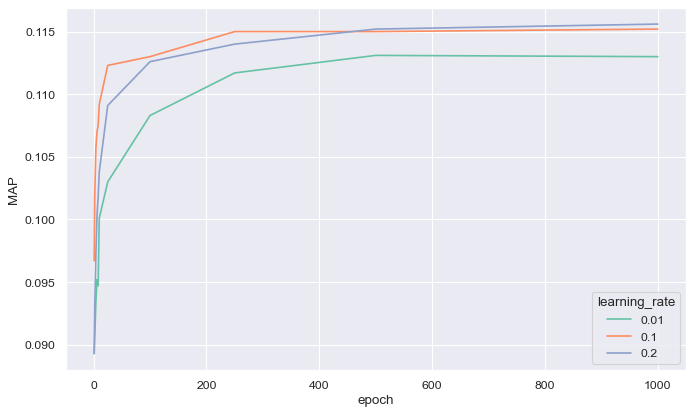

In [13]:
sns.set()
from matplotlib.pyplot import figure
figure(figsize=(10, 6), dpi=80)
sns.lineplot(data=hyperparameters_df,x="epoch",y=hyperparameters_df["MAP"],hue="learning_rate",palette=sns.color_palette('Set2', n_colors=3))
plt.show()

### Since the change between 500 epochs and 1000 epochs is only 0.0004, the number of epochs are not increased. 

## The value of MAP is highest when learning rate is 0.2 and the number of epochs is 1000. This is the final model chosen  for making recommendations. 

In [14]:
# Final model after selecting the learning rate and epochs
final_model = LightFM(loss = "warp",learning_rate=0.2)

final_model.fit(train_set, user_features=None, item_features=None, 
sample_weight=None, epochs=1000, num_threads=4,verbose=False)


## 5.5 Making sample recommendations

In [15]:
#Getting recommendations for user 1 with the final model
scores=final_model.predict(1, np.arange(len(products_in_matrix)))  # predict for user 1
recommended_items=products_in_matrix.iloc[np.argsort(-scores)][:8]    # arrange in descending order of prob. and select 8
print(recommended_items.values)                                    # display recommended items

['Total 2% with Strawberry Lowfat Greek Strained Yogurt' 'Banana'
 'Total 2% Lowfat Greek Strained Yogurt with Peach'
 'Total 2% Lowfat Greek Strained Yogurt With Blueberry'
 'Total 2% All Natural Greek Strained Yogurt with Honey'
 'Total 0% Raspberry Yogurt'
 'Total 2% Greek Strained Yogurt with Cherry 5.3 oz' 'Honeycrisp Apple']


In [16]:
#Getting recommendations for user 2 with the final model
scores=final_model.predict(2, np.arange(len(products_in_matrix)))  # predict for user 2
recommended_items=products_in_matrix.iloc[np.argsort(-scores)][:8]    # arrange in descending order of prob. and select 8
print(recommended_items.values)                                    # display recommended items

['Organic Baby Spinach' 'Organic Strawberries' 'Bag of Organic Bananas'
 'Banana' 'Organic Blueberries' 'Large Lemon' 'Organic Hass Avocado'
 'Organic Avocado']


In [17]:
#Performance:
ap = precision_at_k(model = final_model, 
                        test_interactions = test_set,
                        num_threads = 4,k=8, check_intersections = False)

print("average MAP = {0:.{1}f}".format(ap.mean(), 4))

average MAP = 0.1156


## 5.6 Business impact v1

For a given customer order, it is assumed that the customer would not have purchased the product if it was not recommended to them.

Based on this assumption, and using 
    
    Average cart size = 8 items
    No. of recommendations = 8
    AP = MAP = 0.1156 (Since MAP is mean of AP, we assume AP is equal to MAP here)
    
(1/8)*(sum of ratio of products purchased per each recommendation) Should be approximately equal to 0.1156


Scenario 1: Customer purchases 1st item that is recommended but nothing else.

    Avg Precision = (1/8)((1/1)+0+0+0+0+0+0+0)= 0.125

Scenario 2: Customer purchases 2nd and 3rd recommendation alone.

    Avg Precision = (1/8)(0+(1/2)+(2/3)+0+0+0+0+0+0)= 0.1137

And so on. 

### So, the customer purchases at least 1 product extra that they would not have purchased if it wasn't recommended. This means an increase in order size of 12.5% (from 8 to 9). This will help improving the revenue.

## 5.6 Business impact v2

For a given customer order, it is assumed that the customer would not have purchased the product if it was not recommended to them.

Based on this assumption, and using 
    
    Average cart size = 8 items
    No. of recommendations = 8
    AP = MAP = 0.1156 (Since MAP is mean of AP, we assume AP is equal to MAP here)
    
(1/8)*(sum of ratio of products purchased per each recommendation) Should be approximately equal to 0.1156


Scenario 1: Customer purchases 1st item that is recommended but nothing else.

    Avg Precision = (1/8)((1/1)+0+0+0+0+0+0+0)= 0.125

Scenario 2: Customer purchases 2nd and 3rd recommendation alone.

    Avg Precision = (1/8)(0+(1/2)+(2/3)+0+0+0+0+0+0)= 0.1137

And so on. So, the customer purchases 1 to 4 products that are recommended by the final model.

### So, we are able to predict at least 12.5% of the items that would be in a user's cart. The additional recommendations that have not been purchased can still be recommended to the customer as these products have been purchased by similar users. 

Based on the customer responses collected from those recommendations, the model can be further improved to make more relevant recommendations and improve revenue.

## 5.7 Summary

So, based on the user-product interaction, the recommendations can be made to customers to increase revenue and profit. Though MAP is higher for the LightFM model, the model has to be validated online and metrics like Clickthrough Rate, Conversion Rate, Long Term customer value also need to be validated.

For customers without interactions, we could use our naive model of recommending the highest selling products. For new products, the similarity can be calculated among products for recommendation.

## 5.8 Further Work

The models built here does not take into consideration the user's features (metadata) as well as product's features. This can be included to evaluate model performance. Also, historical price of products might help in understanding why a customer bought a product at a certain point of time. A basic recommendation system is built here which can be improved by adding features to the model and changing the other hyperparameters.